# Examplary office Chilled Water consumption prediction usning LSTM Model

Energy consumption forecasting for buildings has immense value in energy efficiency and sustainability research. Accurate energy forecasting models have numerous implications in planning and energy optimization of buildings and campuses. For new buildings, where past recorded data is unavailable, computer simulation methods are used for energy analysis and forecasting future scenarios. However, for existing buildings with historically recorded time series energy data, statistical and machine learning techniques have proved to be more accurate and quick

## Imports

In [1]:
# Data analysis packages:
import pandas as pd
import numpy as np
pd.set_option('display.float_format', lambda x: '%.3f'%x)

# Visualization packages:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

import warnings
import itertools
import datetime as dt
from IPython.display import HTML # to see everything
warnings.filterwarnings("ignore")

Import sklearn and statsmodels 

In [2]:
# import sklearn 
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error

Import tensorflow and Keras

In [3]:
import tensorflow as tf

# print 
print(tf.__version__)
print(tf.keras.__version__)

2.0.0-beta0
2.2.4-tf


Import my functions

In [4]:
# import plots as p
import supervised_learning as sl
# helper_functions as hf 
import visualization as vis
# import data_prep as dp
%load_ext autoreload
%autoreload 2

## Load Dataset -- Electricity

In [5]:
office = pd.read_csv('data_folder/office_data.csv')#, index_col=['timestamp'], parse_dates=['timestamp'])
office = pd.read_csv('data_folder/office_1249.csv', index_col=['timestamp'], parse_dates=['timestamp'])
usecols =['meter', 'meter_reading', 'air_temperature', 'cloud_coverage', 'dew_temperature','precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']
office = office[usecols]
print('Dataset record for building_id = 1249:', office.shape)
office.head(3)

Dataset record for building_id = 1249: (35136, 9)


,meter,meter_reading,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
timestamp,,,,,,,,,
2016-01-01,0,299.000,nan,nan,nan,nan,nan,nan,nan
2016-01-01,1,695.555,nan,nan,nan,nan,nan,nan,nan
2016-01-01,2,899.640,nan,nan,nan,nan,nan,nan,nan


In [6]:
# forward and backward fill for missing time sereis observations
office_temp = office.ffill()
office_data = office_temp.bfill()
office_data.head(3)

,meter,meter_reading,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
timestamp,,,,,,,,,
2016-01-01,0,299.000,5.600,0.000,-0.600,0.000,1019.500,300.000,2.600
2016-01-01,1,695.555,5.600,0.000,-0.600,0.000,1019.500,300.000,2.600
2016-01-01,2,899.640,5.600,0.000,-0.600,0.000,1019.500,300.000,2.600


now we do not have any missing values, I can take out the electricity consumption for this machine learning project and do some explanatory data analysis

In [7]:
# electricity constumption for building_id 1249
elec_consumption = office_data[office_data['meter']==0]
elec_consumption.drop(columns=['meter'], inplace=True)
print(elec_consumption.shape)
elec_consumption.head(3)

(8784, 8)


,meter_reading,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
timestamp,,,,,,,,
2016-01-01 00:00:00,299.000,5.600,0.000,-0.600,0.000,1019.500,300.000,2.600
2016-01-01 01:00:00,298.000,5.600,0.000,-0.600,0.000,1019.500,300.000,2.600
2016-01-01 02:00:00,299.000,5.600,4.000,-0.600,0.000,1019.500,300.000,2.600


In [10]:
elec_consumption.isin([0]).sum()

meter_reading          154
air_temperature        127
cloud_coverage        5883
dew_temperature        152
precip_depth_1_hr     7791
sea_level_pressure       0
wind_direction        1243
wind_speed            1190
dtype: int64

## Exploratory Data Analysis or (EDA)

In [9]:
# %load -r 14-27 visualization.py

The energy consumption is in kWh (or equivalent). Note that this is real data with measurement error, which we expect will impose a baseline level of modeling error.

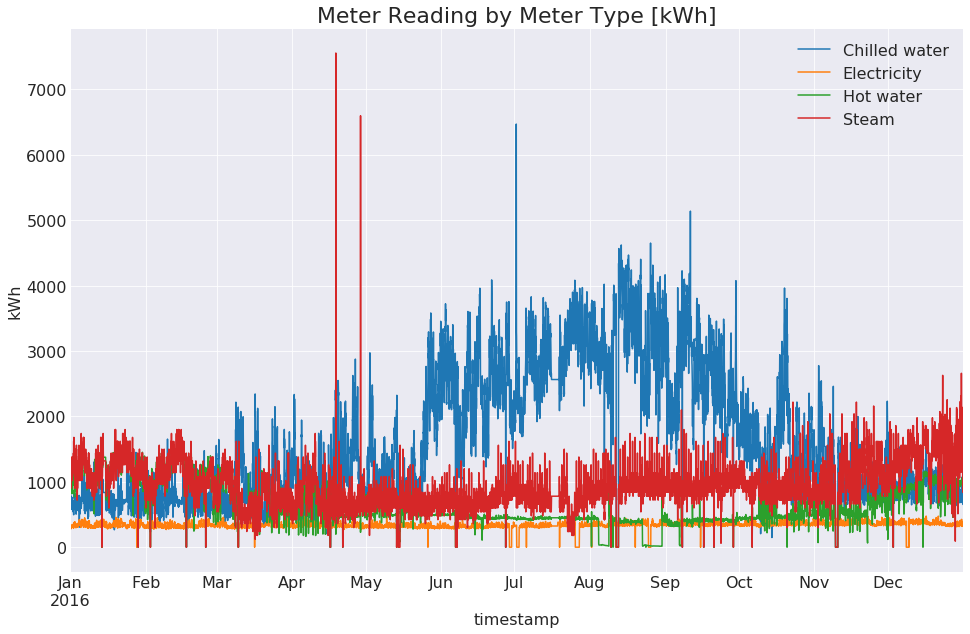

In [11]:
# plot 
vis.median_meter_reading(office_data)
# plt.savefig('image/meter_reading_by_type')

In [ ]:
# office_data.head()

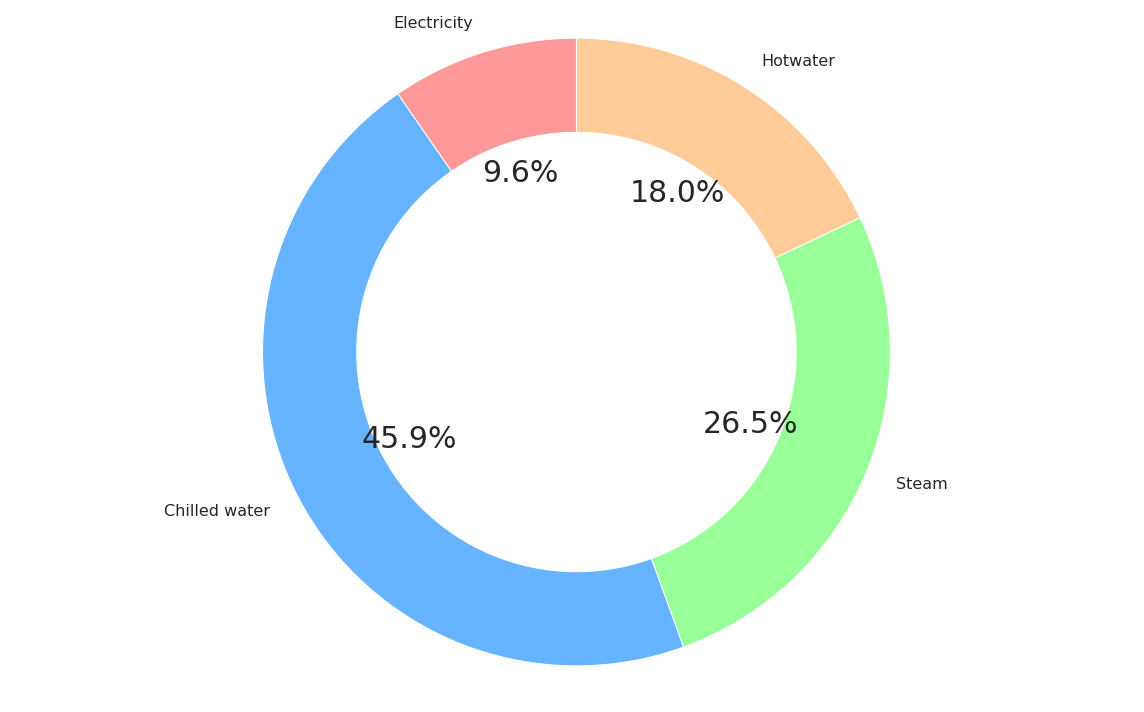

In [12]:
# fig, ax = plt.subplots(figsize=(6, 13), subplot_kw=dict(aspect="equal"))
labels = 'Electricity', 'Chilled water', 'Steam', 'Hotwater'
sizes = list(office_data.groupby(by='meter')['meter_reading'].sum())
# colors
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
 
fig1, ax1 = plt.subplots()
ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90, textprops={'fontsize':30})
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
# plt.title('percent energy cosumption by meter type')
plt.show()
# plt.savefig('image/pie_chart.png')

### Box plots and outlier detection

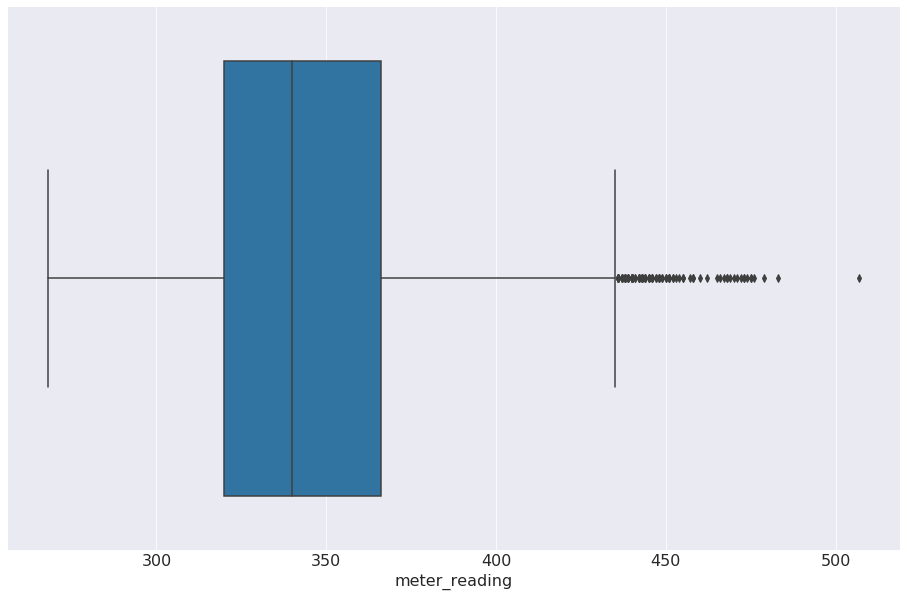

In [9]:
elec_consumption['meter_reading'].replace(to_replace=0, method='ffill', inplace=True)
ax = sns.boxplot(x=elec_consumption["meter_reading"])

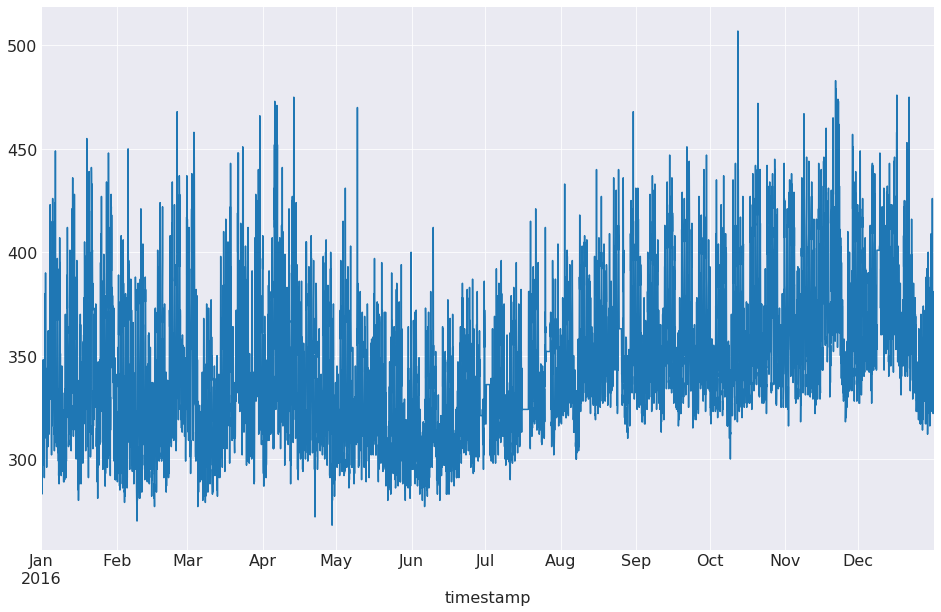

In [10]:
elec_consumption['meter_reading'].plot()

In [ ]:
# B=plt.boxplot(elec_consumption.meter_reading)
# [item.get_ydata() for item in B['whiskers']]

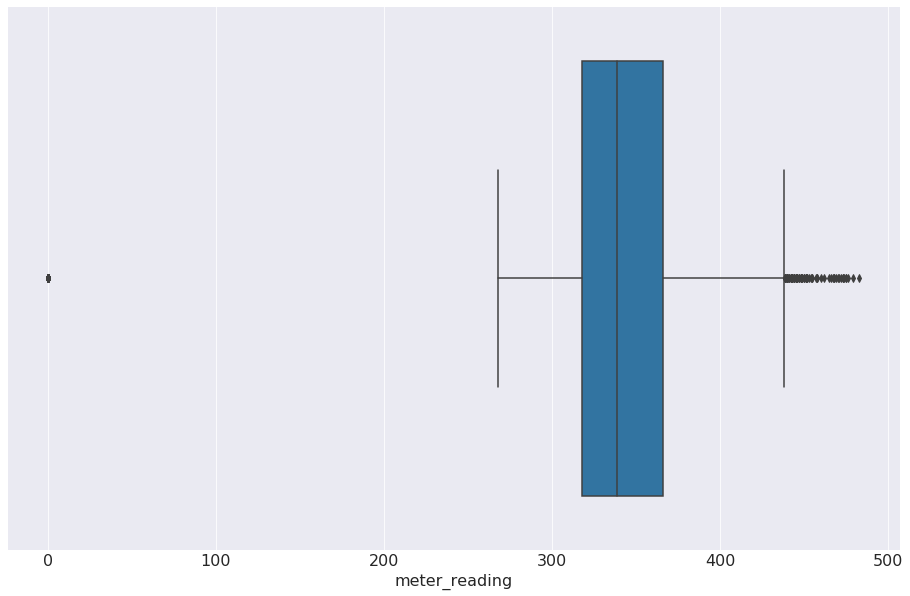

In [13]:
whiskers = 500
median = elec_consumption.loc[elec_consumption['meter_reading'] < whiskers, 'meter_reading'].median()
elec_consumption['meter_reading'] = np.where(elec_consumption['meter_reading'] > whiskers, median, elec_consumption['meter_reading'])
ax = sns.boxplot(x=elec_consumption["meter_reading"])

In [14]:
# %load -r 97-128 visualization.py

In [15]:
import visualization as vis

In [59]:
elec_consumption['meter_reading'].replace(to_replace=0, method='ffill', inplace=True)

In [60]:
elec_consumption.isin([0]).sum()

meter_reading            0
air_temperature        127
cloud_coverage        5883
dew_temperature        152
precip_depth_1_hr     7791
sea_level_pressure       0
wind_direction        1243
wind_speed            1190
dtype: int64

(<matplotlib.axes._subplots.AxesSubplot at 0x7ff00aaf7a90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff0081e1208>)

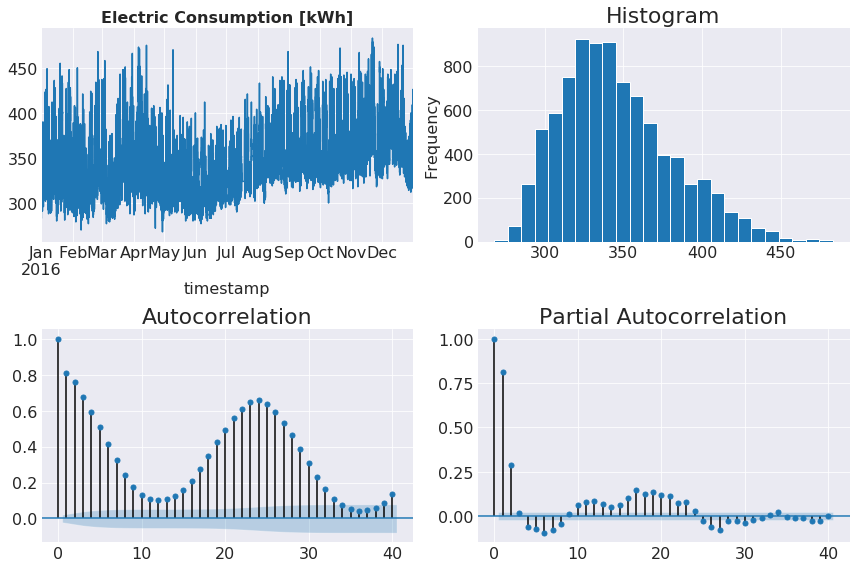

In [55]:
y = elec_consumption.meter_reading
vis.tsplot(y, 'Electric Consumption [kWh]', lags=40)

In [61]:
import plotly.graph_objects as go
import plotly
from plotly.subplots import make_subplots
plotly.offline.init_notebook_mode(connected=True)

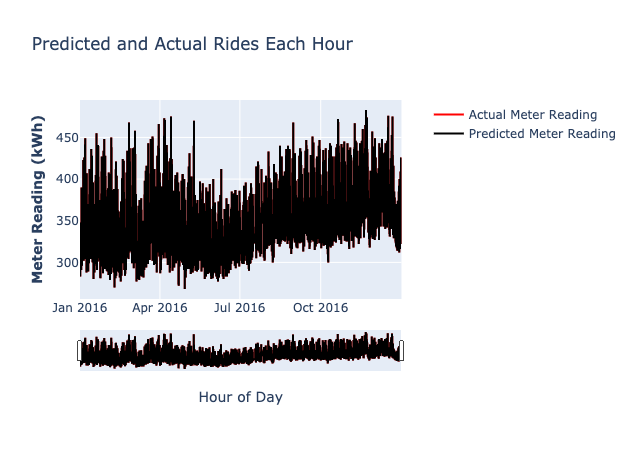

In [62]:
# Make subplot figure 
fig = make_subplots(specs=[[{"secondary_y": True}]])
# Add traces; weekday and weekend aggregate rides
fig.add_trace(go.Scatter(x=elec_consumption.index, y=elec_consumption['meter_reading'], name="Actual Meter Reading",
                         line_color='red'))
fig.add_trace(go.Scatter(x=elec_consumption.index, y=elec_consumption['meter_reading'], name="Predicted Meter Reading",
                         line_color='black'), secondary_y=False)
fig.update_layout(title_text='Predicted and Actual Rides Each Hour')
# Set x-axis title
fig.update_xaxes(title_text="Hour of Day")
# Set y-axes titles
fig.update_yaxes(title_text="<b>Meter Reading (kWh)</b> initiated", secondary_y=False)
fig.update_yaxes(title_text="<b>Meter Reading (kWh)</b>", secondary_y=False)
# Include x-axis slider
fig.update_layout(xaxis_rangeslider_visible=True)
fig.show()

### Stationarity

In [63]:
import testing_functions as testf

checking statinarlity and comfiriming all are statinary

In [64]:
# col_len = list(elec_consumption.columns)
# for i in col_len:
#     testf.test_stationarity(elec_consumption[i])

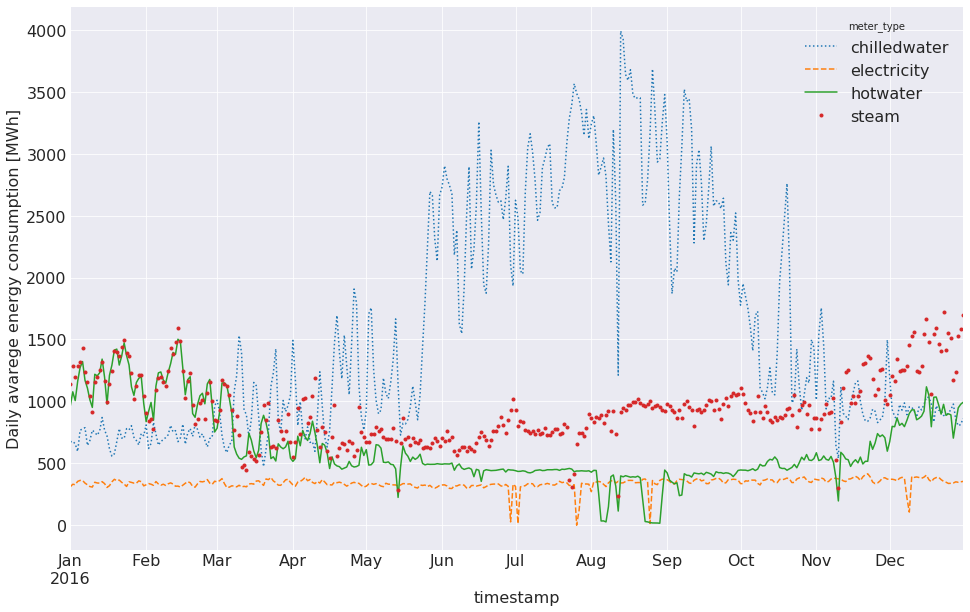

In [65]:
temp_df = office[['meter_reading', 'meter']]
meter_mapping = {0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'}
temp_df['meter_type'] = temp_df['meter'].map(meter_mapping)
building_1249 = temp_df.pivot(columns='meter_type', values='meter_reading', )
# building_1249.head()
daily = building_1249.resample('D').mean()
daily.plot(style=[':', '--', '-', '.'], figsize=(16,10), grid=True)
plt.ylabel('Daily avarege energy consumption [MWh]');

In [19]:
# %load -r 81-95 visualization.py

In [20]:
# rolling_statistics(daily, col='electricity')

test stationarity

In [21]:
# %load -r 131-146 visualization.py

plot acf and pacf plots

In [22]:
# %load -r 148-157 visualization.py

In [23]:
# %load -r 160-167 visualization.py

In [24]:
from statsmodels.tsa.stattools import adfuller

In [25]:
# stationarity_autocorrelation_test_original(daily, col='electricity')

In [26]:
import statsmodels.api as sm

# Change to daily 

In [81]:
# elec_consumption.head()

In [74]:
daily_elec_consumption = elec_consumption.resample('D').mean()
print(daily_elec_consumption.shape)
daily_elec_consumption.head()

(366, 8)


,meter_reading,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
timestamp,,,,,,,,
2016-01-01,310.667,4.004,2.083,-3.171,0.000,1017.854,290.417,3.342
2016-01-02,330.750,1.762,1.083,-7.617,0.000,1017.562,284.167,3.058
2016-01-03,326.875,1.525,0.000,-5.329,-0.042,1012.167,206.250,2.704
2016-01-04,353.792,-0.900,0.667,-10.067,0.000,1015.188,325.417,4.621
2016-01-05,361.792,-8.258,0.000,-19.346,0.000,1032.083,306.667,4.662


plot a time series plot

### Seasonality

## Features and labels
for this capstone project, I wanted to build a model that will predict the future energy consumption and air temperature variation as a function of all other eight features.

In [82]:
target_names = ['meter_reading']
shift_days = 3
shift_steps = shift_days * 24 # I wanted to shift the record by shift_steps hours.
df_targets = daily_elec_consumption[target_names].shift(-shift_days)
df_targets.head(3)

,meter_reading
timestamp,
2016-01-01,353.792
2016-01-02,361.792
2016-01-03,361.208


to check we successfully shifted by 24 hours, I took the 24 to 27 records from the original data

In [83]:
daily_elec_consumption[target_names].iloc[3:7]

,meter_reading
timestamp,
2016-01-04,353.792
2016-01-05,361.792
2016-01-06,361.208
2016-01-07,340.042


good! new we succesfully shifted by 24 hours, let us split the data set into feature and target.

In [85]:
# features
x_data = daily_elec_consumption.values[0:-shift_days]
print('    Feature Shape:', x_data.shape)
 
# target
y_data = df_targets.values[:-shift_days]
print('    Target Shape:', y_data.shape)

    Feature Shape: (363, 8)
    Target Shape: (363, 1)


In [86]:
# These are the input-signals for the training- and test-sets:
num_data = len(x_data)
train_split = 0.85
num_train = int(train_split * num_data)
num_test = num_data - num_train
print('Training observations:', num_train)
print('Validation observations:', num_test)
x_train = x_data[0:num_train]
x_test  = x_data[num_train:]
print('Total observations:', (len(x_train) + len(x_test)))

Training observations: 308
Validation observations: 55
Total observations: 363


In [87]:
# Check the shape
x_train.shape, x_test.shape

((308, 8), (55, 8))

In [88]:
# These are the output-signals for the training- and test-sets:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
print('Total test observations:', (len(y_train) + len(y_test)))
y_train.shape, y_test.shape

Total test observations: 363


((308, 1), (55, 1))

In [89]:
num_x_signals = x_data.shape[1] # 8
num_y_signals = y_data.shape[1] # 1
print('Number of input-signals:', num_x_signals, 'and shape:', x_train.shape )
print('Number of output-signals:', num_y_signals, 'and shape', y_train.shape)

Number of input-signals: 8 and shape: (308, 8)
Number of output-signals: 1 and shape (308, 1)


## Scaled Data

In [90]:
print('Min and Max x_train data')
print('    Min:', np.min(x_train))
print('    Max:', np.max(x_train))
x_scaler = MinMaxScaler() # feature_range=(0, 1)
x_scaled_train = x_scaler.fit_transform(x_train)
print('Min and Max x_train_scaled data')
print('    Min:', np.min(x_scaled_train))
print('    Max:', np.max(x_scaled_train))

Min and Max x_train data
    Min: -23.62499999999999
    Max: 1034.5416666666667
Min and Max x_train_scaled data
    Min: 0.0
    Max: 1.0


In [91]:
x_scaled_test = x_scaler.transform(x_test)
print('Min and Max x_test data')
print('    Min:', np.min(x_test))
print('    Max:', np.max(x_test))

# target MinMaxScaler
y_scaler = MinMaxScaler() # feature_range=(-1, 1)
y_scaled_train = y_scaler.fit_transform(y_train)
y_scaled_test = y_scaler.transform(y_test)
print('Min and Max y_test_scaled data')
print('    Min:', np.min(y_scaled_test))
print('    Max:', np.max(y_scaled_test))

Min and Max x_test data
    Min: -16.96666666666667
    Max: 1036.0416666666667
Min and Max y_test_scaled data
    Min: 0.42213297634984315
    Max: 1.271753681392235


The data we have now is one long-time series with 20 input signals so that each time step has 8 input signals and 2 output signals

## Data Generator

In [92]:
print(x_scaled_train.shape)
print(y_scaled_train.shape)
print('----------')
print(x_scaled_test.shape)
print(y_scaled_test.shape)

(308, 8)
(308, 1)
----------
(55, 8)
(55, 1)


call the batch generator function and create a training bach

In [93]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_scaled_train[idx:idx+sequence_length]
            y_batch[i] = y_scaled_train[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

The above function will break the long-time series signal into small subsequences and create a batch so that we can use that for training the network

```python
reshape input to be [samples, time steps, features]
```

In [95]:
# reshape input to be [samples, time steps, features]
batch_size = 64 # batch size of 32 is a good starting point, and you should also try with 64, 128, and 256.
sequence_length = shift_days #shift_steps # 24 * 7

# create the batch-generator
generator = batch_generator(batch_size, sequence_length)

# test the batch-generator to see if it works 
x_batch, y_batch = next(generator)
print(x_batch.shape)
print(y_batch.shape)

(64, 3, 8)
(64, 3, 1)


we get a batch output where we have a batch size of 64 sequences, each sequence has 24, and 8 input signals and 2 output signals. 

In [97]:
signal_list = list(daily_elec_consumption.columns)
print('length of signals:', len(signal_list))

# signal plot for electricity consumption
batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 8 input-signals.
seq = x_batch[batch, :, signal]
# plt.plot(seq);

length of signals: 8


In [98]:
# y plot for electricity consumption
seq = y_batch[batch, :, signal] # only two output signals
# plt.plot(seq);

I create a validation dataset from the testing data

In [99]:
validation_data = (np.expand_dims(x_scaled_test, axis=0),
                   np.expand_dims(y_scaled_test, axis=0))

In [100]:
print('x_test_validation', validation_data[0].shape)
print('y_test_validation', validation_data[1].shape)

x_test_validation (1, 55, 8)
y_test_validation (1, 55, 1)


## Create the Recurrent Neural Network Architecture
from pyhon ``` tf.keras.models ``` import Sequential

In [101]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding, LSTM, Dropout
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import (EarlyStopping, ModelCheckpoint,
                                               TensorBoard, ReduceLROnPlateau, CSVLogger)

### Initalize the RNN
Now let us instantiate an RNN model

In [137]:
# clear a model
tf.keras.backend.clear_session()

In [138]:
# Initializing RNN 
elec_dropout_model = Sequential()

#### Adding the LSTM layers and some Dropout regularization

In [139]:
from keras import regularizers

In [140]:
# Adding the first LSTM layer and some Dropout regularisation
elec_dropout_model.add(LSTM(units=100, return_sequences=True, dropout=0.2,
                            input_shape=(None, num_x_signals,)))

In [141]:
# Adding the second LSTM layer and some Dropout regularisation
elec_dropout_model.add(LSTM(units=100, return_sequences=True, dropout=0.2))

In [142]:
# Adding the thired LSTM layer and some Dropout regularisation
elec_dropout_model.add(LSTM(units=100, return_sequences=True, dropout=0.2))

In [143]:
# add the dense layer
elec_dropout_model.add(Dense(num_y_signals, activation='sigmoid'))


### Loss Function

In [144]:
warmup_steps = 50

load the loss_mse_warmup function below

In [145]:
# %load -r 41-63 supervised_learning.py

### Compile Model

In [146]:
optimizer = RMSprop(lr=1e-3)
# optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)

In [147]:
# model.compile(loss=loss_mse_warmup, optimizer=optimizer, metrics=['acc'])
# chw_baseline_model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['acc'])
elec_dropout_model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])
elec_dropout_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 100)         43600     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 100)         80400     
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 100)         80400     
_________________________________________________________________
dense (Dense)                (None, None, 1)           101       
Total params: 204,501
Trainable params: 204,501
Non-trainable params: 0
_________________________________________________________________


### Callback Functions

In [148]:
# path_checkpoint = '23_checkpoint.keras'
# path_checkpoint = 'weights/model_weights.best.{epoch:02d}-{val_loss:.2f}.hdf5'
path_checkpoint = 'weights/model_weights_elec_dropout_daily.h5'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                     monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [149]:
callback_tensorboard = TensorBoard(log_dir='./logs/',
                                   histogram_freq=0,
                                   write_graph=False) #'./23_logs/'

In [150]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [151]:
csv_logger = CSVLogger('logs/elec_dropout_model_daily.csv')

In [152]:
# callback lists 
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr,
             csv_logger] # check the logger

### Fit the RNN to the training set 

In [153]:
%%time
elec_dropout_history = elec_dropout_model.fit_generator(generator=generator,
                    epochs=20,
                    steps_per_epoch=100,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/20
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
 98/100 [============================>.] - ETA: 0s - loss: 0.0484 - mse: 0.0484
Epoch 00001: val_loss improved from inf to 0.08372, saving model to weights/model_weights_elec_dropout_daily.h5
100/100 [==============================] - 14s 143ms/step - loss: 0.0484 - mse: 0.0484 - val_loss: 0.0837 - val_mse: 0.0837
Epoch 2/20
 97/100 [============================>.] - ETA: 0s - loss: 0.0479 - mse: 0.0479
Epoch 00002: val_loss improved from 0.08372 to 0.08283, saving model to weights/model_weights_elec_dropout_daily.h5
100/100 [==============================] - 2s 21ms/step - loss: 0.0480 - mse: 0.0480 - val_loss: 0.0828 - val_mse: 0.0828
Epoch 3/20
 97/100 [============================>.] - ETA: 0s - loss: 0.0472 - mse: 0.0472
Epoch 00003: val_loss did not improve from 0.08283

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
100/100 [=================

## Evaluate the model

In [154]:
elec_dropout_model.evaluate(validation_data[0], validation_data[1])

1/1 [==============================] - 0s 112ms/sample - loss: 0.1910 - mse: 0.1910


[0.1909639686346054, 0.19096397]

In [155]:
elec_dropout_model.evaluate(x_batch, y_batch)

64/64 [==============================] - 2s 25ms/sample - loss: 0.0498 - mse: 0.0498


[0.04983448423445225, 0.049834486]

In [87]:
# this is also a validation test
result = elec_dropout_model.evaluate(x=np.expand_dims(x_scaled_test, axis=0),
                        y=np.expand_dims(y_scaled_test, axis=0))

1/1 [==============================] - 2s 2s/sample - loss: 0.0306 - mse: 0.0306


In [88]:
print("loss (test-set):", result)

loss (test-set): [0.030600091442465782, 0.030600091]


[autoreload of visualization failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.5/dist-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/usr/lib/python3.5/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/usr/lib/python3.5/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 626, in _exec
  File "<frozen importlib._bootstrap_external>", line 669, in exec_module
  File "<frozen importlib._bootstrap_external>", line 775, in get_code
  File "<frozen importlib._bootstrap_external>", line 735, in source_to_code
  File "<frozen importlib._bootstrap>", line 222, in _call_with_frames_removed
  File "/home/jupyter/capstone/visualization.py", line 266
    font=dict(family="Courier 

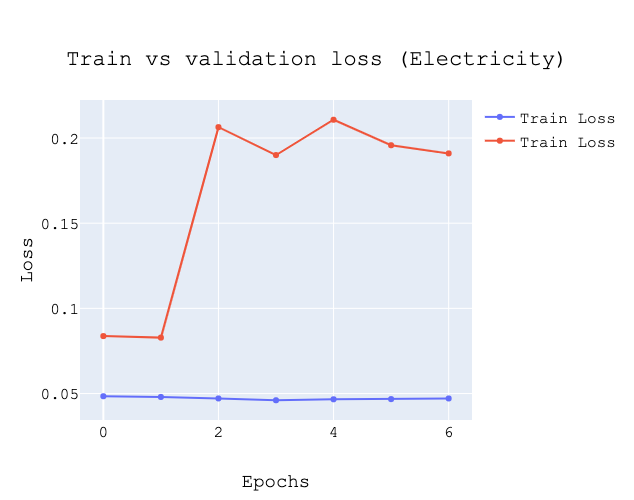

In [165]:
vis.plot_train_vs_val_loss(history=elec_dropout_history, a='Electricity')

## prediction plot

In [159]:
date_train = daily_elec_consumption.index[:num_train]
date_test = daily_elec_consumption.index[num_train:-shift_days]
# data_train_train = chw_consumption.index[700:num_train]
print(len(date_train))
print(len(date_test))

308
55


In [163]:
x_scaled_test.shape

(55, 8)

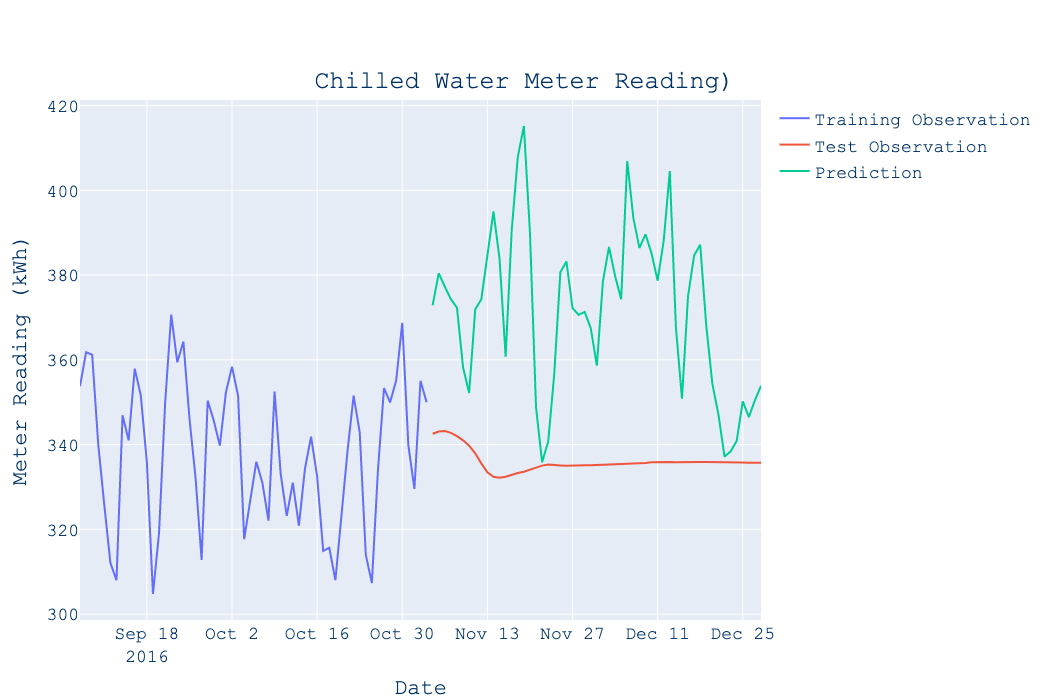

In [164]:
# prediction = model.predict_generator(test_generator)

x = np.expand_dims(x_scaled_test, axis=0)
y_pred = elec_dropout_model.predict(x)
y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])


y_train_reshaped = y_train.reshape((-1))
y_test_reshaped = y_test.reshape((-1))
y_pred_reshaped = y_pred_rescaled.reshape((-1))

trace1 = go.Scatter(
    x = daily_elec_consumption.index[250:num_train],
    y = y_train_reshaped,
    mode = 'lines',
    name = 'Training Observation'
)
trace2 = go.Scatter(
    x = date_test,
    y = y_pred_reshaped,
    mode = 'lines',
    name = 'Test Observation'
)
trace3 = go.Scatter(
    x = date_test,
    y = y_test_reshaped,
    mode='lines',
    name = 'Prediction'
)
layout = go.Layout(width=1400, height=700,
    title = {'text': "Chilled Water Meter Reading)", 'y':0.9, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'},
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Meter Reading (kWh)", }
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.update_layout(font=dict(family="Courier New, monospace", size=18, color="#003366", )) # "#7f7f7f"
# fig.write_image('image/time_series_forcast_chw.png')
fig.show()

load plot comparision plot

In [ ]:
# %load -r 30-66 visualization.py
def plot_comparison(start_idx, length=100, train=True, model=None):
    
    if train:
        # Use training-data.
        x = x_scaled_train
        y_true = y_train
    else:
        # Use test-data.
        x = x_scaled_train
        y_true = y_test
    
    end_idx = start_idx + length
    
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    x = np.expand_dims(x, axis=0)

    y_pred = model.predict(x)
    
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    
    signal_pred = y_pred_rescaled[:, signal]

    signal_true = y_true[:, signal]

    plt.figure(figsize=(15,5))

    plt.plot(signal_true, label='true')
    plt.plot(signal_pred, label='pred')

    p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)

    plt.ylabel(target_names[signal])
    plt.title('Train vs validation loss (Electricity)', fontsize=22)
    plt.ylabel('meter_r', fontsize=20)
    plt.xlabel('time', fontsize=20)
    sns.set_context("paper", font_scale=1.3)
    sns.set_style('white')
    plt.xticks(fontsize=12), plt.yticks(fontsize=12)
    plt.legend(fontsize=16)
    plt.show()

In [ ]:
plot_comparison(start_idx=6000, length=500, train=True, model=elec_dropout_model)


### Example from test set

In [ ]:
plot_comparison(start_idx=1000, length=500, train=False, model=elec_dropout_model)

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [ ]:
def calculate_errors(train=True, model=None):
    
    if train:
        # Use training-data.
        x = x_scaled_train
        y_true = y_train
        print('Traning data:')
    else:
        # Use test-data.
        x = x_scaled_test
        y_true = y_test
        print('Testing data:')
    
    x = np.expand_dims(x, axis=0)

    y_pred = model.predict(x)
    
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    for signal in range(len(target_names)):
        signal_pred = y_pred_rescaled[:, signal]

        signal_true = y_true[:, signal]
        
        print('    Mean Absolute Error:', mean_absolute_error(signal_true, signal_pred))
        print('    Root Mean Squared Error:',np.sqrt(mean_squared_error(signal_true, signal_pred)))

In [ ]:
calculate_errors(train=True, model=elec_dropout_model)

In [ ]:
calculate_errors(train=False, model=elec_dropout_model)

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(elec_dropout_history.history['loss'], label='Train Loss')
plt.plot(elec_dropout_history.history['val_loss'], label='Test Loss')
plt.title('Train vs validation loss (Electricity)', fontsize=22)
plt.ylabel('Loss', fontsize=20)
plt.xlabel('Epochs', fontsize=20)
plt.xticks(fontsize=12), plt.yticks(fontsize=12)
plt.legend(loc='upper right', fontsize=14)
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
plt.savefig('image/model_loss_elec')
plt.show();

In [ ]:
elec_dropout_history.history.keys()

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(elec_dropout_history.history['mse'], label='Train Accuracy')
plt.plot(elec_dropout_history.history['val_mse'], label='Test Accuracy')
plt.title('train vs validation MSE ccuracy for electricity', fontsize=20)
plt.ylabel('accuracy', fontsize=16)
plt.xlabel('epochs', fontsize=16)
plt.xticks(fontsize=12), plt.yticks(fontsize=12)
plt.legend(loc='upper right', fontsize=14)
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
plt.show();

# # 2nd_LSTM Model
this model uses an upgrade on batch size
- softmax activation
- optimizer adam 
- batch size 72

In [ ]:
# reshape input to be [samples, time steps, features]
batch_size = 64
# sequence_length = shift_steps # 24 * 7

# create the batch-generator
generator = batch_generator(batch_size, sequence_length)

# test the batch-generator to see if it works 
x_batch, y_batch = next(generator)
print(x_batch.shape)
print(y_batch.shape)

In [ ]:
# reshape input to be [samples, time steps, features]
# batch_size_2 = 30
# sequence_length = shift_steps # 24 * 7

# create the batch-generator
# generator_2 = batch_generator(batch_size_2, sequence_length)

# test the batch-generator to see if it works 
x_batch, y_batch = next(generator)
print(x_batch.shape)
print(y_batch.shape)

In [ ]:
# clear a model
tf.keras.backend.clear_session()

In [ ]:
# Initializing RNN 
chw_dropout_model = Sequential()

#### Adding the LSTM layers and some Dropout regularization

In [ ]:
# Adding the first LSTM layer and some Dropout regularisation
chw_dropout_model.add(LSTM(units=50, return_sequences=True, #kernel_regularizer=regularizers.l2(0.01),
#                            activity_regularizer=regularizers.l1(0.01),
                           input_shape=(None, num_x_signals,)))
chw_dropout_model.add(Dropout(0.4))
# model.summary()

In [ ]:
# Adding the second LSTM layer and some Dropout regularisation
chw_dropout_model.add(LSTM(units=50, return_sequences=True, #kernel_regularizer=regularizers.l2(0.01),
#                 activity_regularizer=regularizers.l1(0.01)
                          ))
chw_dropout_model.add(Dropout(0.4))
# model.summary()

In [ ]:
chw_dropout_model.add(Dense(num_y_signals, activation='sigmoid', #kernel_regularizer=regularizers.l2(0.01),
#                 activity_regularizer=regularizers.l1(0.01)
                           ))

if False:
    from tensorflow.python.keras.initializers import RandomUniform

#     # Maybe use lower init-ranges.
    init = RandomUniform(minval=-0.05, maxval=0.05) # I ca

    chw_dropout_model.add(Dense(num_y_signals,
                                activation='linear', #kernel_regularizer=regularizers.l2(0.01), #linear
                                #activity_regularizer=regularizers.l1(0.01),
                                kernel_initializer=init))

In [ ]:
# optimizer = RMSprop(lr=1e-3)
# optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)

In [ ]:
# model.compile(loss=loss_mse_warmup, optimizer=optimizer, metrics=['acc'])
chw_dropout_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['acc'])
chw_dropout_model.summary()

### Fitting the model

In [ ]:
csv_logger = CSVLogger('logs/chw_dropout_model.csv')

In [ ]:
path_checkpoint = 'weights/model_weights_chw_dropout.h5'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                     monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [ ]:
# callback lists 
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr,
             csv_logger] # check the logger

In [ ]:
%%time
chw_dropout_history = chw_dropout_model.fit_generator(generator=generator,
                    epochs=20,
                    steps_per_epoch=50, #100,
                    validation_data=validation_data,
                    callbacks=callbacks)

# Evaluating the model

In [ ]:
chw_dropout_model.evaluate(validation_data[0], validation_data[1])

In [ ]:
chw_dropout_model.evaluate(x_batch, y_batch)

In [ ]:
# x_sis.shape, y_sis.shape

In [ ]:
# compare_cx = data.frame(
#     baseline_train = history.history['loss'],
#     baseline_val = history.history['val_loss'],
#     dropout_train = dropout_history.history['loss'],
#     dropout_val = dropout_history.history['val_loss'])
# ) %>%

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(chw_dropout_history.history['loss'], label='Train Loss')
plt.plot(chw_dropout_history.history['val_loss'], label='Test Loss')
plt.title('Model loss vs validation loss', fontsize=20)
plt.ylabel('loss', fontsize=16)
plt.xlabel('epochs', fontsize=16)
plt.xticks(fontsize=12), plt.yticks(fontsize=12)
plt.legend(loc='upper right', fontsize=14)
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
plt.show();

# Overfitting and underfitting

The accuracy of our model on the validation data would peak after training for a number of epochs, and would then start decreasing.

In other words, our model would overfit to the training data. Learning how to deal with overfitting is important. Although it’s often possible to achieve high accuracy on the training set, what we really want is to develop models that generalize well to testing data (or data they haven’t seen before).

there are two common regularization techniques - weight regularization and dropout 

In [ ]:
# from builtins import *
# from pyensae.languages.rconverter import r2python

In [ ]:
# !sudo pip install antlr4-python2-runtime

In [ ]:
# !pip install pyensae --user
# !sudo pip install antlr4-python2-runtime

In [ ]:
# list all data in history
print(chw_dropout_history.history.keys())
# summarize history for accuracy
plt.plot(chw_dropout_history.history['acc'])
plt.plot(chw_dropout_history.history['val_acc'])
plt.title('Model vs validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# summarize history for loss
plt.plot(chw_dropout_history.history['loss'])
plt.plot(chw_dropout_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
def calculate_errors(train=True, model=None):
    
    if train:
        # Use training-data.
        x = x_scaled_train
        y_true = y_train
        print('Traning data:')
    else:
        # Use test-data.
        x = x_scaled_test
        y_true = y_test
        print('Testing data:')
    
    x = np.expand_dims(x, axis=0)

    y_pred = model.predict(x)
    
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    for signal in range(len(target_names)):
        signal_pred = y_pred_rescaled[:, signal]

        signal_true = y_true[:, signal]
        
        print('    Mean Absolute Error:', mean_absolute_error(signal_true, signal_pred))
        print('    Root Mean Squared Error:',np.sqrt(mean_squared_error(signal_true, signal_pred)))

In [ ]:
plot_comparison(start_idx=4000, length=1000, train=True, model=chw_dropout_model)

### Example from test set

In [ ]:
plot_comparison(start_idx=1000, length=1000, train=False, model=chw_dropout_model)

In [ ]:
calculate_errors(train=True, model=chw_baseline_model)

In [ ]:
calculate_errors(train=True, model=chw_baseline_model)

### Measuring and ploting RMSE

#### Finding Fedaral Holidays

In [ ]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

In [ ]:
df = df_elc.copy()
df = df.reset_index()
df['days'] = df.timestamp.apply(lambda x:1 if x.dayofweek > 5 else 0)
df.days.value_counts()

In [ ]:
cal = calendar()
holidays = cal.holidays(start = df.timestamp.min(), end = df.timestamp.max())
df["holiday"] = df.timestamp.isin(holidays).astype('int')
df.head(3)

#### -- start

As a first step, I instantiate the Sequential class. This will be my model class and I will add LSTM, Dropout and Dense layers to this model. 

the output of the last layer is a tensor with an aritrary batch size and arbitrary sequance length and two output length signals. 